# Импорты

In [1]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q
# !pip install catboost -q
# !pip install shap -q

CPU times: total: 0 ns
Wall time: 4.53 μs


In [2]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import logging
import time
import socket
import sys
import warnings
import seaborn as sns

# Визуализация
import matplotlib.pyplot as plt

# Базы данных
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy

# Машинное обучение - модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

# === Статистика ===
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# === Sklearn ===

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Интерпретация моделей
import shap

# Прогресс-бар
from tqdm import tqdm

# ИМПОРТ ФУНКЦИЙ ПРОЕКТА И КОНФИГУРАЦИИ
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_categorical_columns,
    plot_scatter_with_numerical,
    suggest_param,
    EarlyStoppingCallback
)

from creds import db_config

# НАСТРОЙКА ЛОГГИРОВАНИЯ
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# ОТКЛЮЧЕНИЕ ПРЕДУПРЕЖДЕНИЙ
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Константы

In [3]:
RANDOM_STATE = 20
TEST_SIZE = 0.2
N_JOBS = 2
N_ITER = 10000 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3
EARLY_STOP = 50

# Подключение к базе и получение данных

In [4]:
# Импортируем конфигурацию из отдельного файла
try:
    logger.info("Конфигурация загружена из creds.py")
except ImportError:
    logger.info("Файл creds.py не найден")
    db_config = {
        'user': input("Введите имя пользователя: "),
        'pwd': input("Введите пароль: "),
        'host': input("Введите хост: "),
        'port': input("Введите порт: "),
        'db': input("Введите название БД: ")
    }

2025-11-26 17:46:11 [INFO] __main__: Конфигурация загружена из creds.py


In [5]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-11-26 17:46:11 [INFO] __main__: Хост доступен


True

Хост доступен, можем подключаться и загружать данные.   

In [6]:
# если с хостом все ок, то подключаемся и забираем данные
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        # Определяем тип загрузки
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            # Это SQL-запрос - загружаем напрямую
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            # Это имя таблицы
            table_name = table_name_or_query
            if use_chunks:
                # Загружаем по частям
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                # Загружаем целиком
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [7]:
logger.info("=== ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===")
full_tables_config = {
    'collisions': 'collisions',
    'parties': 'parties', 
    'vehicles': 'vehicles'
}

df_dict_full = load_all_tables_safe(engine, full_tables_config)

# Проверяем что все таблицы загружены
successful_tables = {k: v for k, v in df_dict_full.items() if v is not None}

if len(successful_tables) == len(full_tables_config):
    collisions_default = df_dict_full['collisions']
    parties_default = df_dict_full['parties']
    vehicles_default = df_dict_full['vehicles']
    logger.info("Все полные данные успешно загружены")
else:
    logger.warning(f"Загружены только таблицы: {list(successful_tables.keys())}")

2025-11-26 17:46:11 [INFO] __main__: === ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===
2025-11-26 17:46:11 [INFO] __main__: Загружаем таблицу collisions по частям...
2025-11-26 17:46:11 [INFO] __main__: Всего строк в collisions: 1400000
2025-11-26 17:46:19 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/1400000)
2025-11-26 17:46:27 [INFO] __main__: Загружено 300000 строк (прогресс: 600000/1400000)
2025-11-26 17:46:35 [INFO] __main__: Загружено 300000 строк (прогресс: 900000/1400000)
2025-11-26 17:46:44 [INFO] __main__: Загружено 300000 строк (прогресс: 1200000/1400000)
2025-11-26 17:46:49 [INFO] __main__: Загружено 200000 строк (прогресс: 1400000/1400000)
2025-11-26 17:46:49 [INFO] __main__: collisions: 1400000 строк, 20 столбцов
2025-11-26 17:46:50 [INFO] __main__: Загружаем таблицу parties по частям...
2025-11-26 17:46:50 [INFO] __main__: Всего строк в parties: 2752408
2025-11-26 17:46:53 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/2752408)
2025-11-26 17:46:56 [INFO] __main__: З

In [8]:
collisions_default.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [9]:
parties_default.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [10]:
vehicles_default.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Да, много данных. Посмотрим, как это число изменится если мы сразу получим только то, что нам нужно

В тз у нас есть ограничения на выборку - учтем их сразу в запросах, чтобы не тащить все данные.  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие. Т.е. берем все что до 2013 года.  

Также отберем только нужные признаки, который будут полезны для модели.

# Отбор признаков для модели предсказания виновности в ДТП

## Признаки для модели

Из таблицы `collisions`

| Признак | Обоснование |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `PCF_VIOLATION_CATEGORY` | Ключевой признак - категории нарушений ПДД напрямую коррелируют с виновностью |
| `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |

Из таблицы `parties`

| Признак | Обоснование |
|---------|-------------|
| `PARTY_DRUG_PHYSICAL` | Важный признак - физическое состояние водителя напрямую влияет на виновность |
| `PARTY_SOBRIETY` | Критический признак - состояние трезвости является ключевым фактором определения виновника |
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |

Из таблицы `vehicles`

| Признак | Обоснование |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

## Признаки для исключения из модели

Технические и идентификационные признаки
- `CASE_ID`, `ID` - уникальные идентификаторы, не несут прогнозной способности
- `PARTY_NUMBER` - технический номер участника в рамках ДТП

Географические признаки
- `COUNTY_CITY_LOCATION`, `COUNTY_LOCATION` - без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать
- `DIRECTION` - направление движения само по себе не является информативным признаком

Временные признаки
- `COLLISION_DATE`, `COLLISION_TIME` - рекомендуется вынести в отдельный анализ сезонности и времени суток

Избыточные и производные признаки
- `PRIMARY_COLLISION_FACTOR` - дублирует информацию из `PCF_VIOLATION_CATEGORY`, но в более обобщённой форме
- `PARTY_COUNT` - количество участников ДТП слабо коррелирует с виновностью конкретного водителя
- `DISTANCE` - расстояние от главной дороги без дополнительного контекста не информативно
- `MOTOR_VEHICLE_INVOLVED_WITH` - тип второго участника менее важен, чем действия самого виновника
- `INSURANCE_PREMIUM` - страховая премия является скорее следствием, чем причиной ДТП

Поразмыслив - оставлю DIRECTION и DISTANCE, в целом также придерживаюсь, но оставим выбор за моделью.  
По тз есть задача оценить по месяцам, поэтому COLLISION_DATE пока тоже оставим  

Ретроспектива небольшая:  
1) после мая 2012 у нас данных почти нет, значит для нормальной оценки сезонности надо брать все ДО 2012 года, иначе получим некорректные данные при расчетах  
2) party_drug_physical и location_type - практически пустые признаки, вообще не берем их, чтобы не мешали и не фонили

In [11]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
query = """
SELECT 
    -- Из collisions
    -- c.case_id,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.intersection,
    -- c.location_type,
    c.pcf_violation_category,
    c.type_of_collision,
    c.road_condition_1,
    c.direction,
    c.distance,
    c.collision_date::date,
    c.collision_time::time,
    
    -- Из parties
    p.party_number,
    p.at_fault,
    -- p.party_drug_physical,
    p.party_sobriety,
    p.cellphone_in_use,
    
    -- Из vehicles
    v.vehicle_type,
    v.vehicle_age,
    v.vehicle_transmission
    
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
-- WHERE c.collision_date < '2012-05-01'
WHERE c.collision_date < '2012-01-01'
    AND  c.collision_date > '2008-12-31'
    AND c.collision_damage <> 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age < 11
"""

filtered_tables_config = {
    'df': query
}

2025-11-26 17:47:29 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [12]:
# Загружаем отфильтрованные таблицы
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)

# Проверяем успешность загрузки и создаем переменные
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    df = df_dict_filtered['df']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    # Создаем переменные только для успешно загруженных таблиц
    if 'df' in successful_tables:
        df = df_dict_filtered['df']

2025-11-26 17:47:29 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-26 17:47:39 [INFO] __main__: Загружено: 409212 строк, 18 столбцов
2025-11-26 17:47:39 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.


# EDA

### общие данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409212 entries, 0 to 409211
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   weather_1               407494 non-null  object 
 1   road_surface            406164 non-null  object 
 2   lighting                407219 non-null  object 
 3   intersection            407368 non-null  float64
 4   pcf_violation_category  404324 non-null  object 
 5   type_of_collision       406845 non-null  object 
 6   road_condition_1        406366 non-null  object 
 7   direction               313667 non-null  object 
 8   distance                409212 non-null  float64
 9   collision_date          409212 non-null  object 
 10  collision_time          408661 non-null  object 
 11  party_number            409212 non-null  int64  
 12  at_fault                409212 non-null  int64  
 13  party_sobriety          403100 non-null  object 
 14  cellphone_in_use    

None

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
406458,clear,dry,daylight,0.0,speeding,rear end,normal,north,528.0,2009-10-03,13:42:00,2,0,had not been drinking,0.0,sedan,3,manual
24254,clear,dry,daylight,1.0,automobile right of way,sideswipe,normal,None,0.0,2010-12-16,11:30:00,2,0,had not been drinking,NaN,coupe,5,auto
138313,snowing,snowy,daylight,0.0,speeding,head-on,normal,south,2165.0,2011-04-08,08:20:00,1,1,had not been drinking,0.0,coupe,7,manual
106070,cloudy,dry,daylight,0.0,automobile right of way,sideswipe,normal,south,45.0,2010-03-30,18:14:00,1,1,had not been drinking,0.0,sedan,4,manual
84881,clear,dry,daylight,0.0,speeding,rear end,normal,north,208.0,2011-11-08,07:50:00,2,1,had not been drinking,0.0,sedan,2,manual


weather_1                  1718
road_surface               3048
lighting                   1993
intersection               1844
pcf_violation_category     4888
type_of_collision          2367
road_condition_1           2846
direction                 95545
collision_time              551
party_sobriety             6112
cellphone_in_use          36980
vehicle_transmission       4294
dtype: int64

None

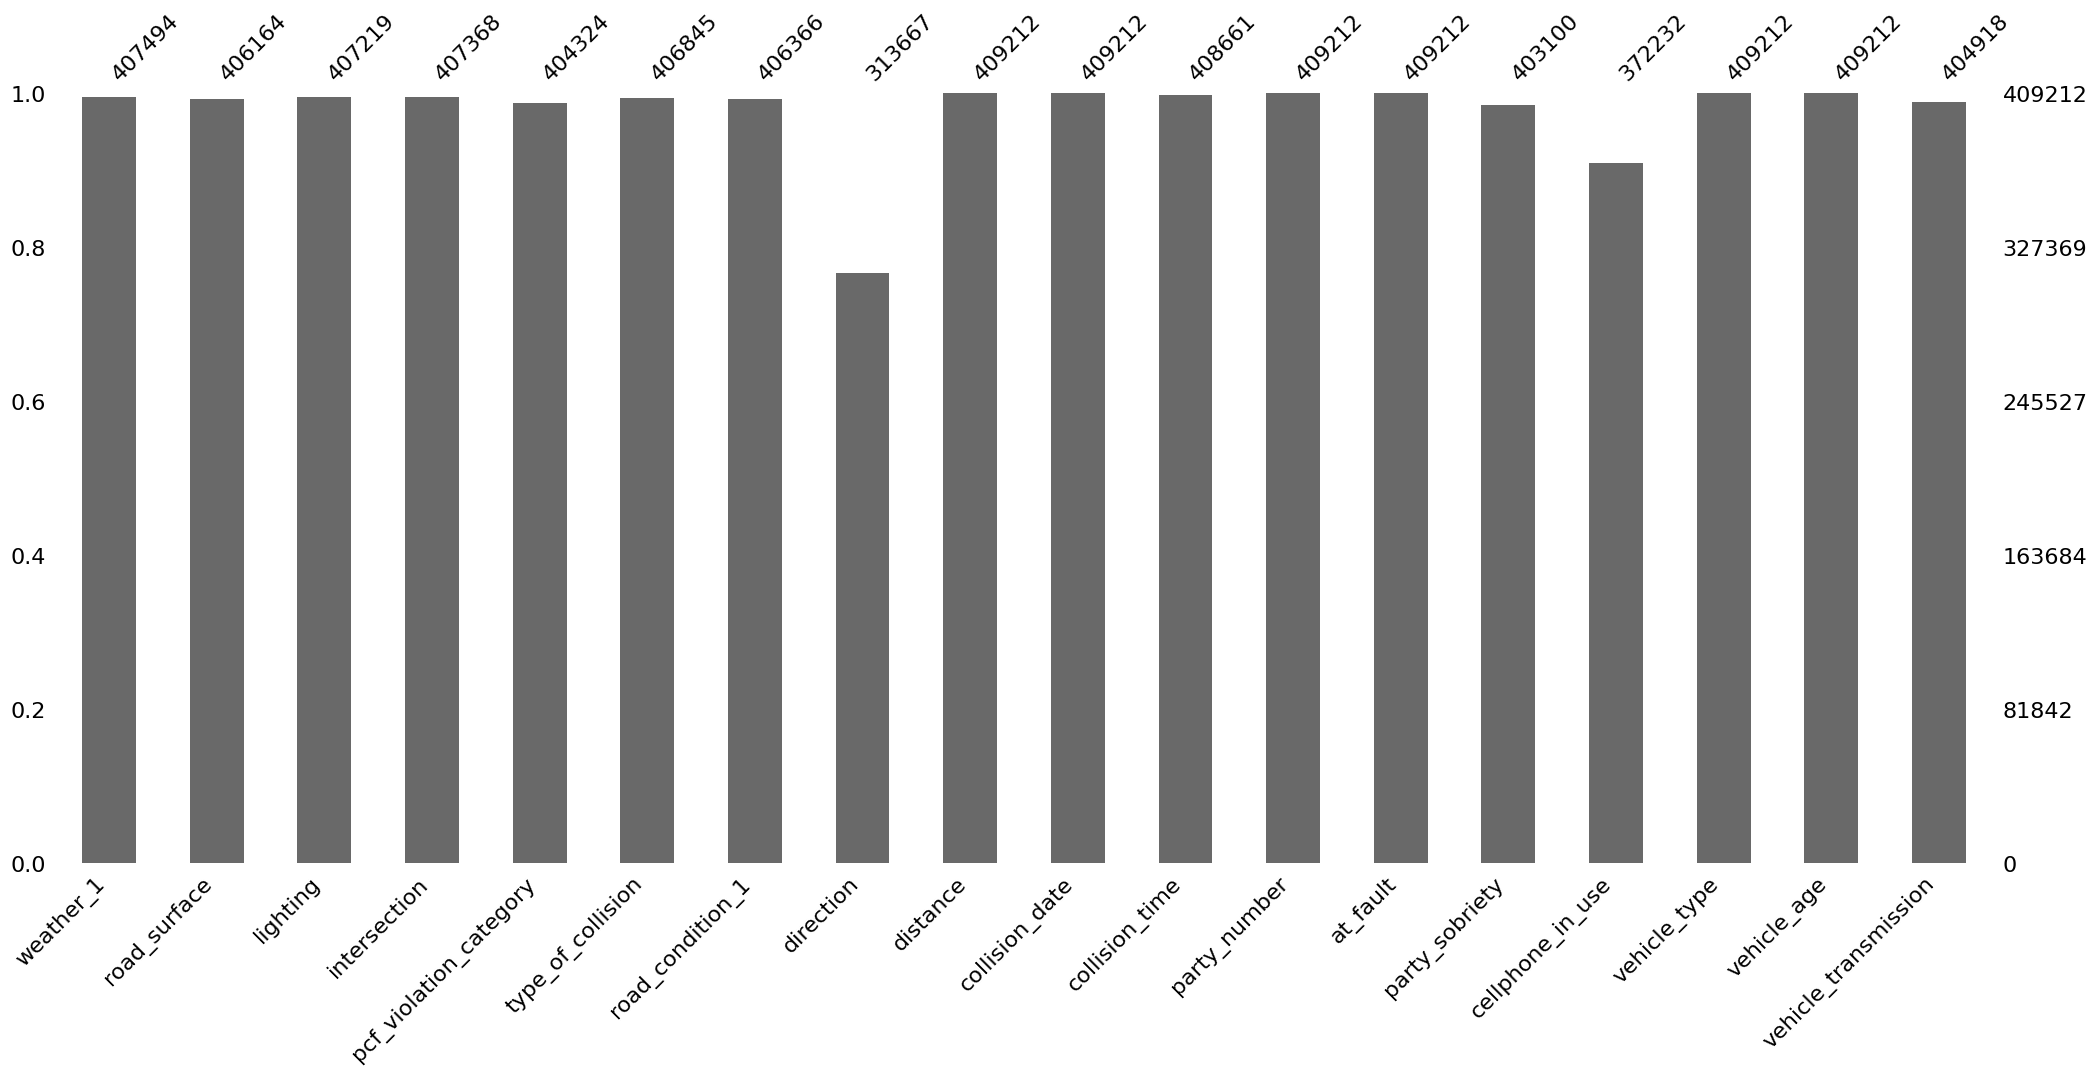

,count,mean,std,min,25%,50%,75%,max
intersection,407368.0,0.223245,0.416422,0.0,0.0,0.0,0.0,1.0
distance,409212.0,938.950826,27347.112321,0.0,7.0,125.0,528.0,8363520.0
party_number,409212.0,1.526290,0.662826,1.0,1.0,1.0,2.0,13.0
at_fault,409212.0,0.499076,0.500000,0.0,0.0,0.0,1.0,1.0
cellphone_in_use,372232.0,0.019047,0.136691,0.0,0.0,0.0,0.0,1.0
vehicle_age,409212.0,4.349367,2.590474,0.0,3.0,4.0,6.0,10.0


,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
0,cloudy,wet,dark with no street lights,0.0,other than driver (or pedestrian),other,normal,south,500.0,2009-03-22,05:30:00,1,0,had not been drinking,0.0,sedan,2,auto
1,clear,dry,daylight,1.0,automobile right of way,broadside,normal,None,0.0,2009-02-23,17:35:00,2,0,had not been drinking,0.0,sedan,1,manual
2,clear,dry,dark with street lights,1.0,automobile right of way,head-on,normal,None,0.0,2009-03-13,20:12:00,1,1,had not been drinking,0.0,sedan,5,auto
3,clear,dry,daylight,0.0,other than driver (or pedestrian),broadside,normal,north,45.0,2009-05-03,17:28:00,1,0,had not been drinking,NaN,sedan,3,auto
4,clear,dry,dark with no street lights,0.0,unsafe lane change,hit object,normal,south,1000.0,2009-07-05,00:10:00,1,1,impairment unknown,NaN,coupe,6,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409207,clear,dry,dark with street lights,1.0,improper turning,rear end,normal,None,0.0,2011-10-31,18:25:00,1,1,had not been drinking,NaN,coupe,2,manual
409208,cloudy,dry,dark with street lights,0.0,dui,sideswipe,normal,west,528.0,2011-10-30,19:41:00,1,1,"had been drinking, under influence",0.0,coupe,9,manual
409209,clear,dry,daylight,0.0,improper turning,broadside,normal,south,100.0,2011-10-14,10:29:00,1,1,had not been drinking,0.0,sedan,0,auto
409210,clear,dry,daylight,1.0,speeding,rear end,normal,None,0.0,2011-10-19,11:28:00,2,0,had not been drinking,0.0,sedan,6,manual


In [13]:
check_data(df)

Пу-пу-пу....  
1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  

PS вначале посмотрим на результаты с такими данными, а потом попробуем удалить все пропуски и сравним результаты моделей

### детальные данные

Детальнее изучим каждый признак

In [14]:
logger.info("Все столбцы таблицы:")
logger.info(", ".join(df.columns))
logger.info("="*50)

exclude_columns = ['case_id', 'collision_date', 'collision_time', 'distance']  # для исключения

for col in df.columns:
    if col not in exclude_columns:
        display(f"{col}: ", end="")
        display(df[col].unique())

2025-11-26 17:47:43 [INFO] __main__: Все столбцы таблицы:
2025-11-26 17:47:43 [INFO] __main__: weather_1, road_surface, lighting, intersection, pcf_violation_category, type_of_collision, road_condition_1, direction, distance, collision_date, collision_time, party_number, at_fault, party_sobriety, cellphone_in_use, vehicle_type, vehicle_age, vehicle_transmission
2025-11-26 17:47:43 [INFO] __main__: ==================================================


'weather_1: '

array(['cloudy', 'clear', 'raining', 'fog', 'snowing', None, 'other',
       'wind'], dtype=object)

'road_surface: '

array(['wet', 'dry', None, 'snowy', 'slippery'], dtype=object)

'lighting: '

array(['dark with no street lights', 'daylight',
       'dark with street lights', 'dusk or dawn',
       'dark with street lights not functioning', None], dtype=object)

'intersection: '

array([ 0.,  1., nan])

'pcf_violation_category: '

array(['other than driver (or pedestrian)', 'automobile right of way',
       'unsafe lane change', 'improper turning', 'dui',
       'following too closely', 'speeding', None,
       'traffic signals and signs', 'other hazardous violation',
       'other equipment', 'other improper driving', 'wrong side of road',
       'improper passing', 'pedestrian violation',
       'unsafe starting or backing', 'unknown', 'hazardous parking',
       'impeding traffic', 'pedestrian right of way', 'fell asleep',
       'lights', 'brakes'], dtype=object)

'type_of_collision: '

array(['other', 'broadside', 'head-on', 'hit object', 'overturned',
       'rear end', 'sideswipe', None], dtype=object)

'road_condition_1: '

array(['normal', 'obstruction', 'other', None, 'flooded', 'construction',
       'holes', 'loose material', 'reduced width'], dtype=object)

'direction: '

array(['south', None, 'north', 'east', 'west'], dtype=object)

'party_number: '

array([ 1,  2,  3,  4,  6,  5,  8,  7, 13,  9, 11, 10, 12])

'at_fault: '

array([0, 1])

'party_sobriety: '

array(['had not been drinking', 'impairment unknown',
       'had been drinking, under influence', None,
       'had been drinking, not under influence', 'not applicable',
       'had been drinking, impairment unknown'], dtype=object)

'cellphone_in_use: '

array([ 0., nan,  1.])

'vehicle_type: '

array(['sedan', 'coupe', 'other'], dtype=object)

'vehicle_age: '

array([ 2,  1,  5,  3,  6,  0,  8,  4,  7, 10,  9])

'vehicle_transmission: '

array(['auto', 'manual', None], dtype=object)

Есть пропуски в данных по многим признакам.  
Все категориальные пропуски заменить на unkwnown.  
Все числовые на -1.  
Но для начала визуаилизация данных

### посмотрим на выбросы

In [15]:
# здесь я хочу посмотреть только на дистанцию до главной дороги
# я честно не понимаю смысл этого признака
# что нам даст информация что дтп произошло в 100 км от главной дороги?!
# удалим пока все что дальше 10км, хотя я бы в принципе удалил все что дальше 1км исключительно с тобой логикой, что за это расстояние водитель уже должен был принять меры
# так и сделаем

df[df['distance'] > 1000]

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
7,clear,dry,daylight,0.0,following too closely,rear end,normal,north,1160.0,2009-08-17,07:32:00,2,0,had not been drinking,0.0,sedan,2,manual
25,cloudy,dry,daylight,0.0,speeding,rear end,normal,north,1320.0,2010-02-12,10:55:00,1,1,had not been drinking,0.0,sedan,5,auto
30,raining,wet,daylight,0.0,dui,hit object,normal,west,2112.0,2010-04-11,16:25:00,1,1,"had been drinking, under influence",0.0,coupe,7,auto
32,clear,dry,dark with no street lights,0.0,speeding,rear end,normal,south,2640.0,2010-05-03,23:40:00,1,1,had not been drinking,0.0,sedan,10,auto
36,clear,dry,daylight,0.0,speeding,rear end,normal,west,1320.0,2010-07-13,07:25:00,2,0,had not been drinking,0.0,coupe,8,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409188,clear,dry,daylight,0.0,unsafe lane change,rear end,normal,north,1500.0,2011-11-07,09:10:00,1,1,had not been drinking,0.0,sedan,9,auto
409191,clear,dry,daylight,0.0,speeding,rear end,normal,south,2640.0,2011-11-02,11:45:00,1,0,had not been drinking,0.0,coupe,3,auto
409192,clear,dry,daylight,0.0,speeding,rear end,holes,north,1056.0,2011-08-30,17:00:00,2,0,had not been drinking,0.0,sedan,4,manual
409203,raining,wet,dark with street lights,0.0,speeding,sideswipe,normal,north,7920.0,2011-11-04,19:20:00,2,0,had not been drinking,0.0,sedan,2,auto


In [16]:
df = df[df['distance'] <= 1000]

### визуализация данных

2025-11-26 17:47:44 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 17:47:44 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 17:47:48 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 17:47:48 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-26 17:47:48 [INFO] matplotlib.category: 

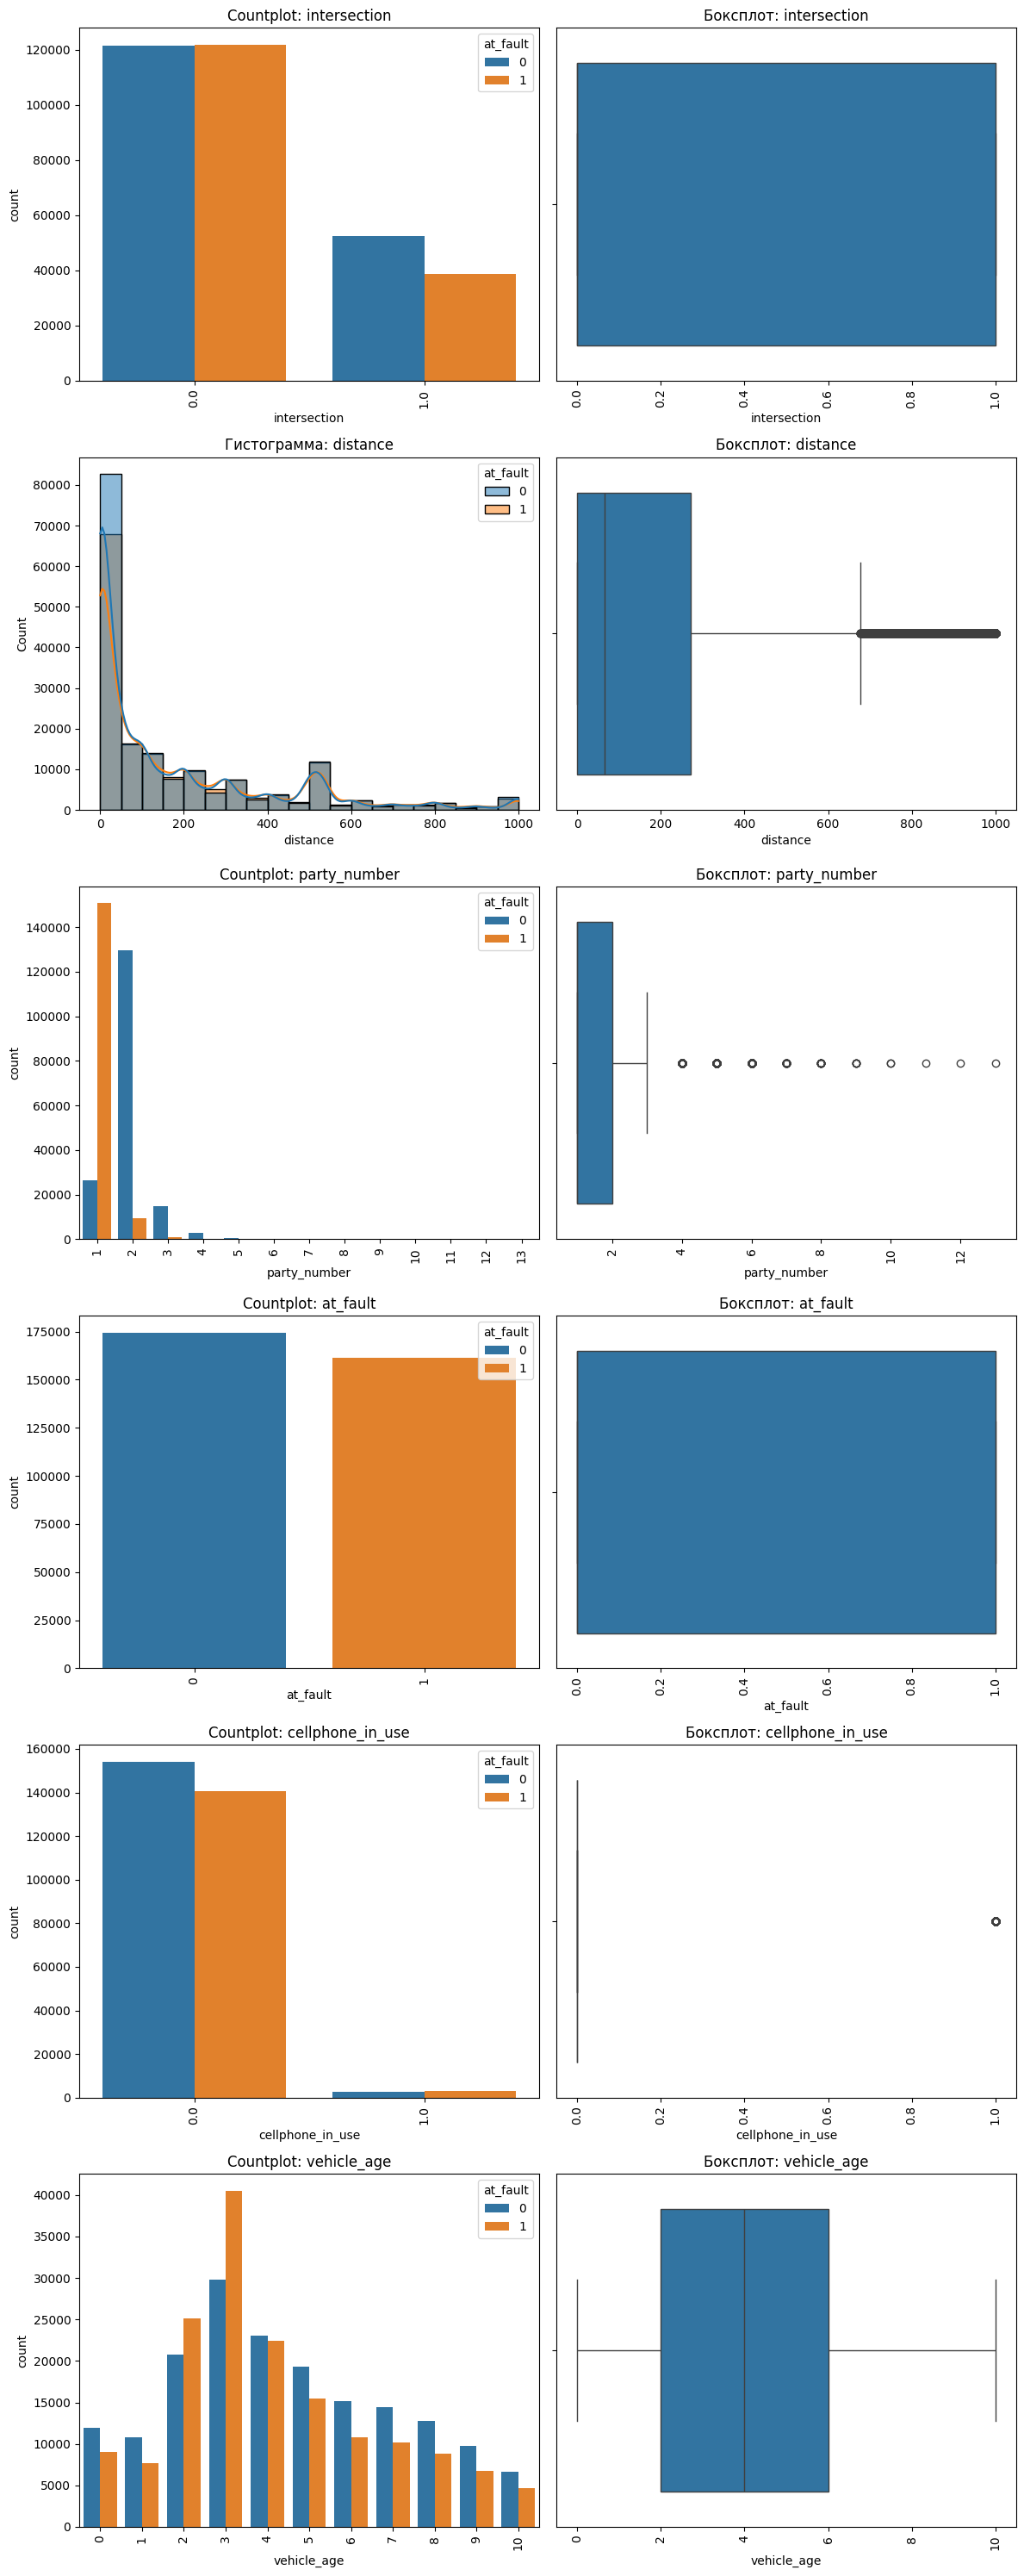

In [17]:
plot_combined(df, col=None, target='at_fault', col_type=None, legend_loc='best')

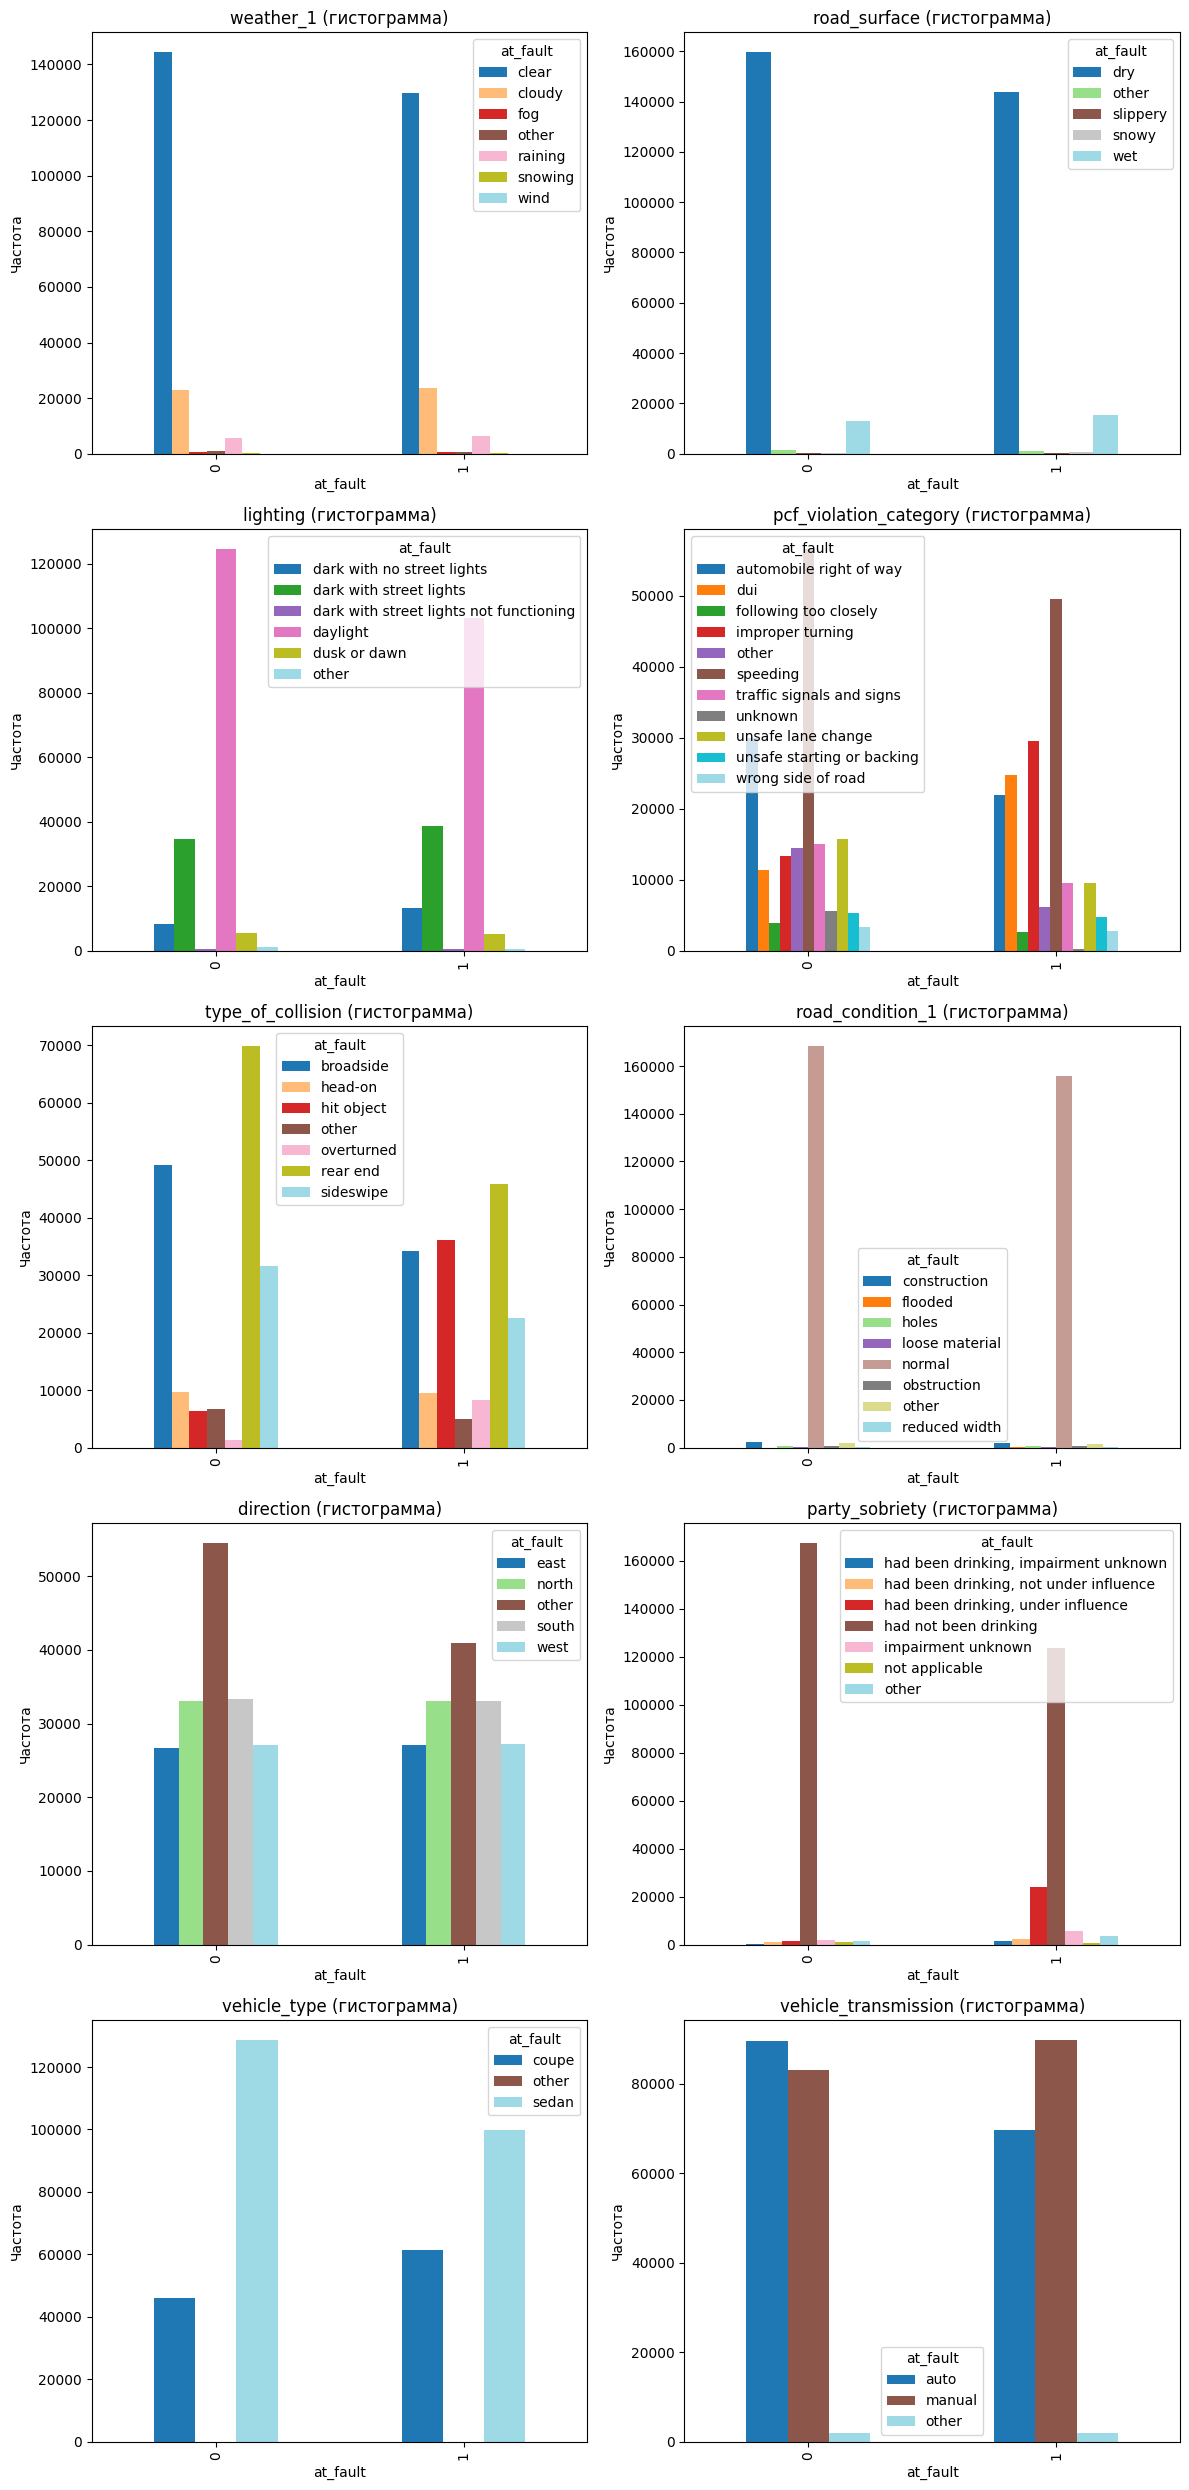

In [18]:
df_for_plot = df.drop(columns=['collision_date', 'collision_time'])
plot_categorical_columns(df_for_plot, col=None, target='at_fault', top_n=10)

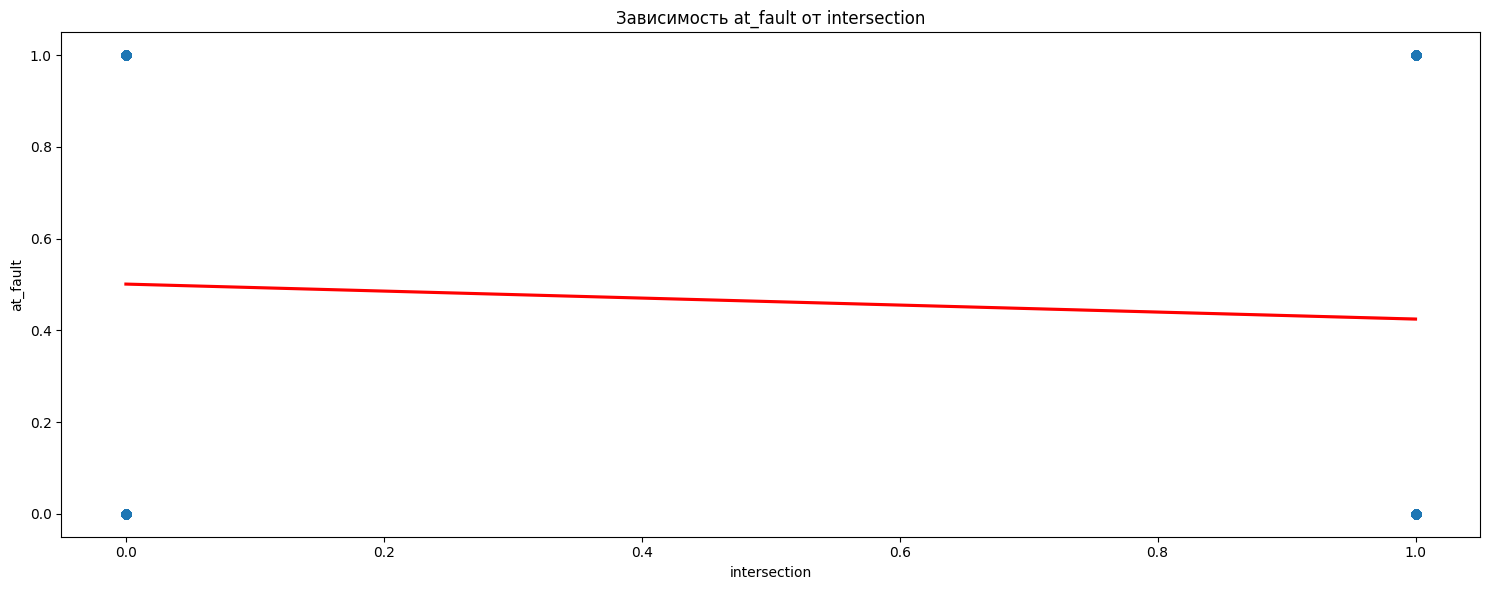

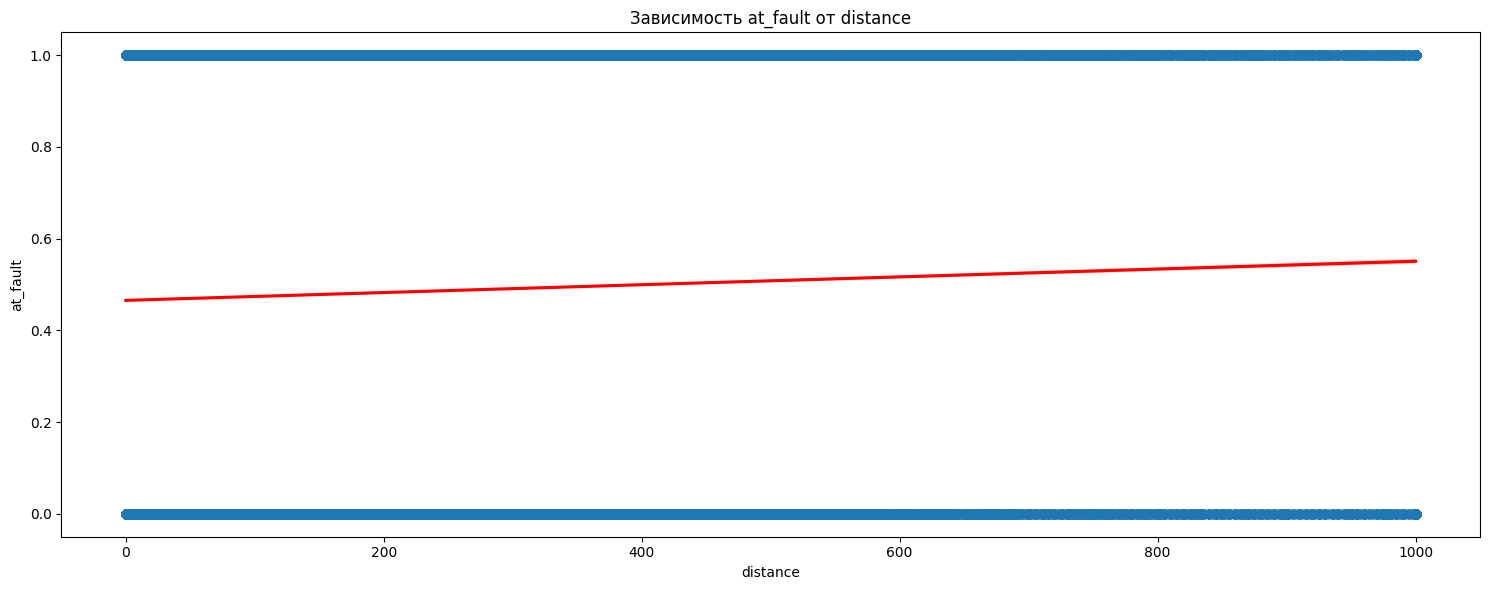

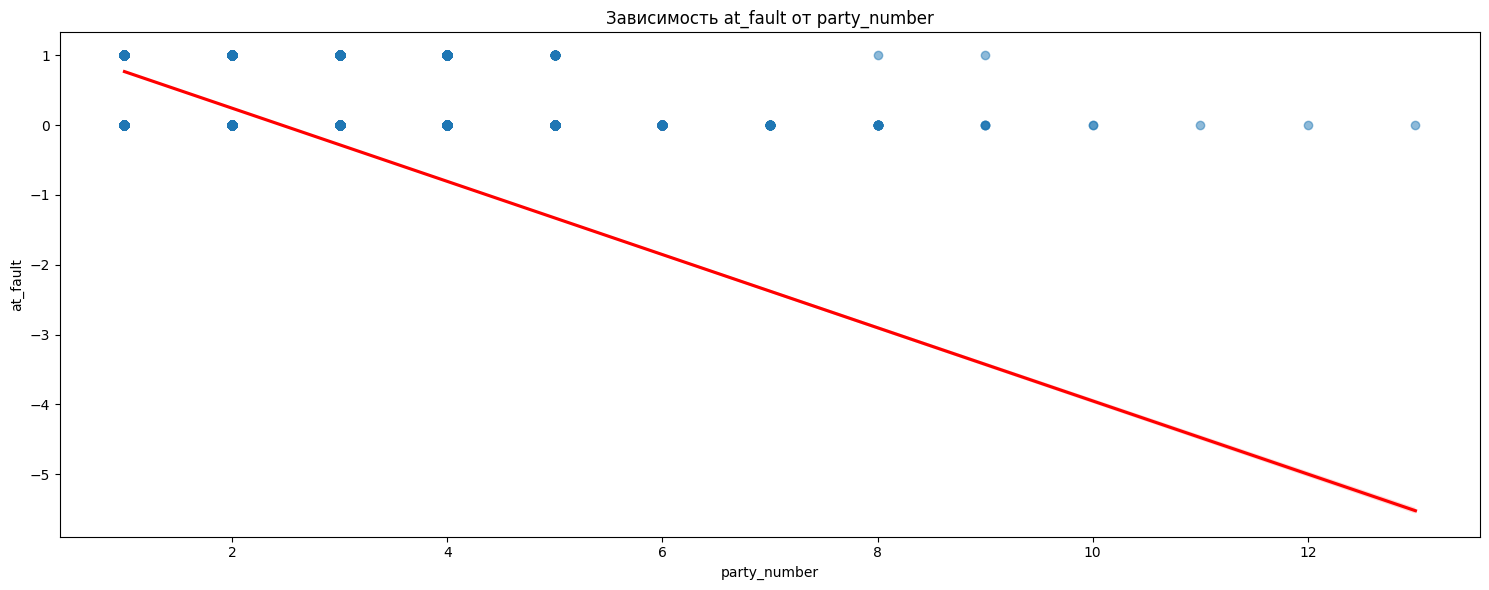

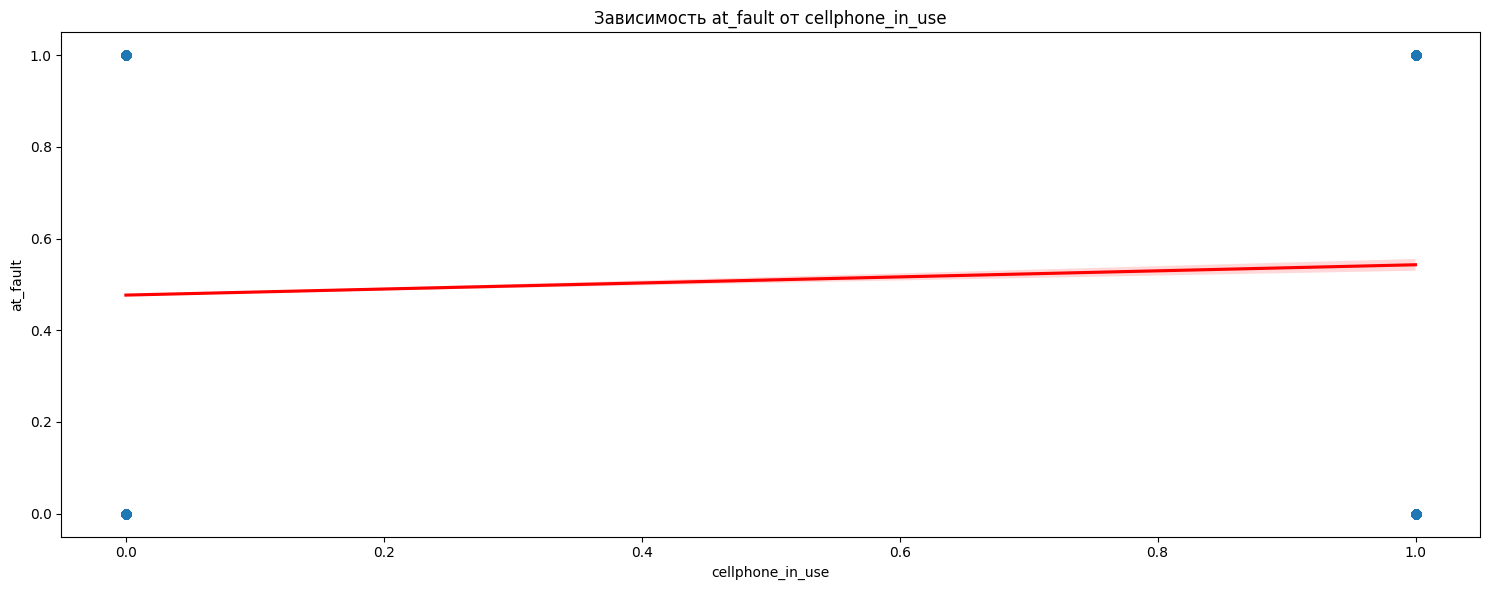

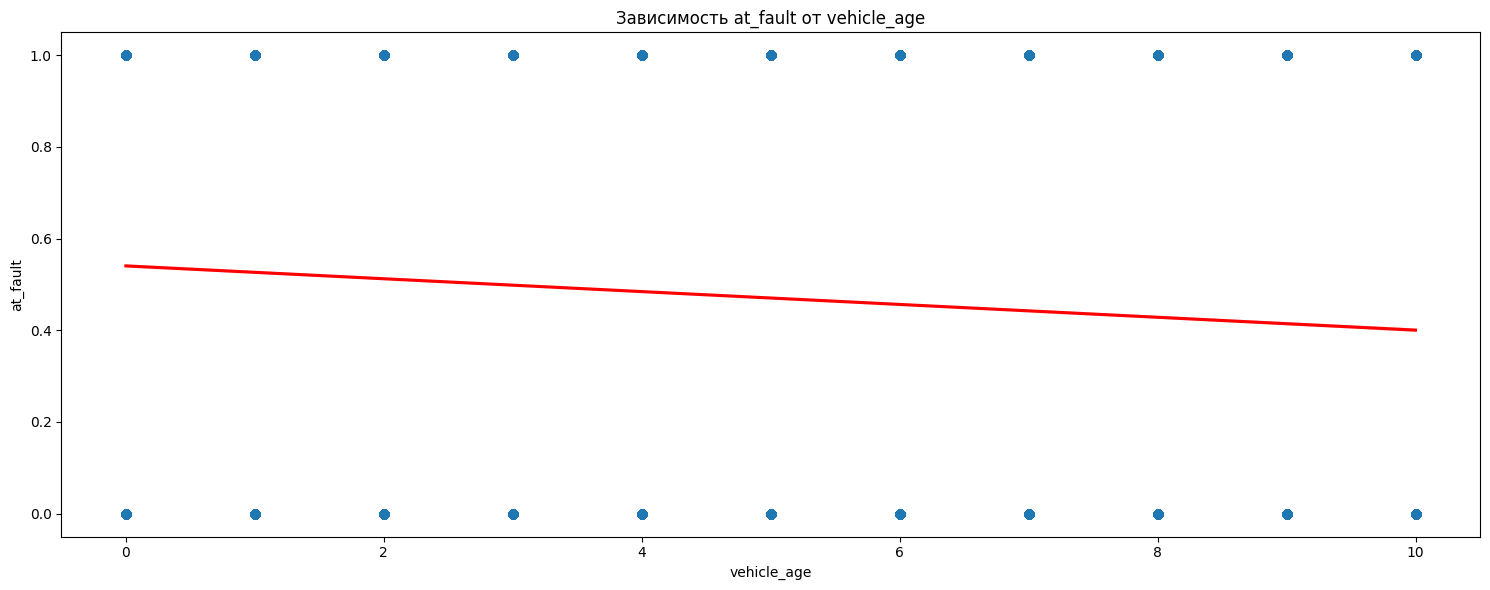

In [19]:
plot_scatter_with_numerical(df, target_column='at_fault')

### распределение по году

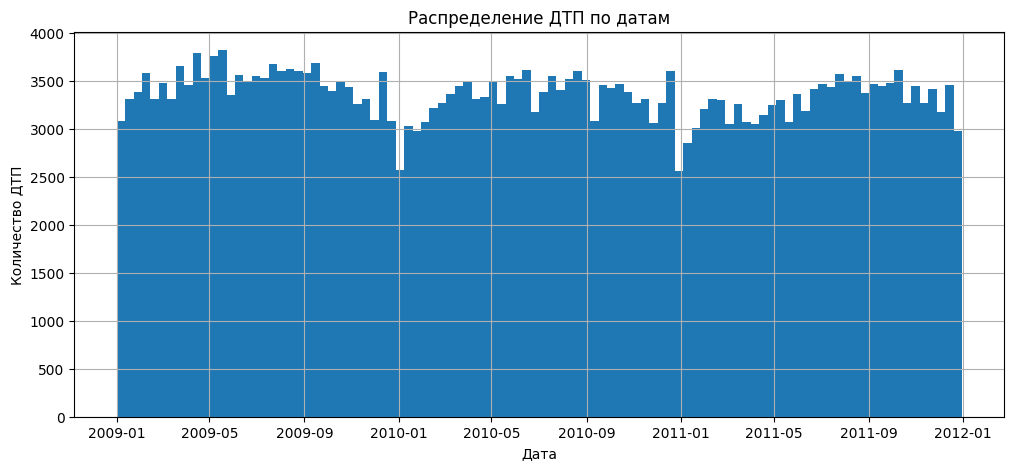

In [20]:
plt.figure(figsize=(12, 5))
df['collision_date'].hist(bins=100)
plt.title('Распределение ДТП по датам')
plt.xlabel('Дата')
plt.ylabel('Количество ДТП')
plt.show()

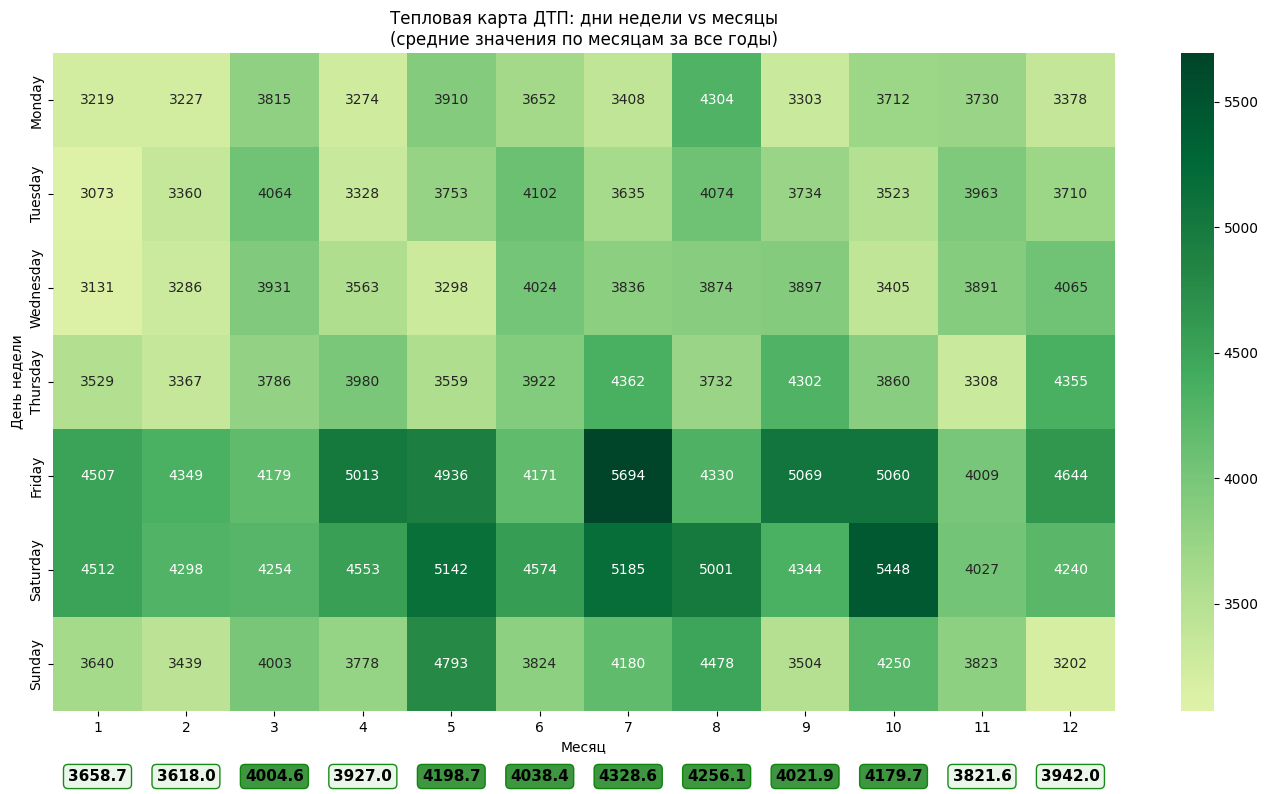

In [21]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot = df.groupby([df['collision_date'].dt.day_name(), df['collision_date'].dt.month]).size().unstack()
pivot = pivot.reindex(days_order)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGn', center=pivot.values.mean())

monthly_means = pivot.mean(axis=0)
mean_of_means = monthly_means.mean()

for i, (month, mean_val) in enumerate(monthly_means.items()):
    if mean_val < mean_of_means:
        # Более светлый зеленый для значений ниже среднего
        color = '#e8f5e8'
        text_color = "#000000"
    else:
        # Более насыщенный зеленый для значений выше среднего
        color = "#298b2c"
        text_color = "#000000"
    
    plt.text(i + 0.5, len(pivot) + 0.7, f'{mean_val:.1f}', 
             ha='center', va='center', fontweight='bold', fontsize=11,
             color=text_color,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.9, edgecolor='green', linewidth=1))

plt.title('Тепловая карта ДТП: дни недели vs месяцы\n(средние значения по месяцам за все годы)')
plt.xlabel('Месяц')
plt.ylabel('День недели')
plt.tight_layout()
plt.show()

### распределение по времени

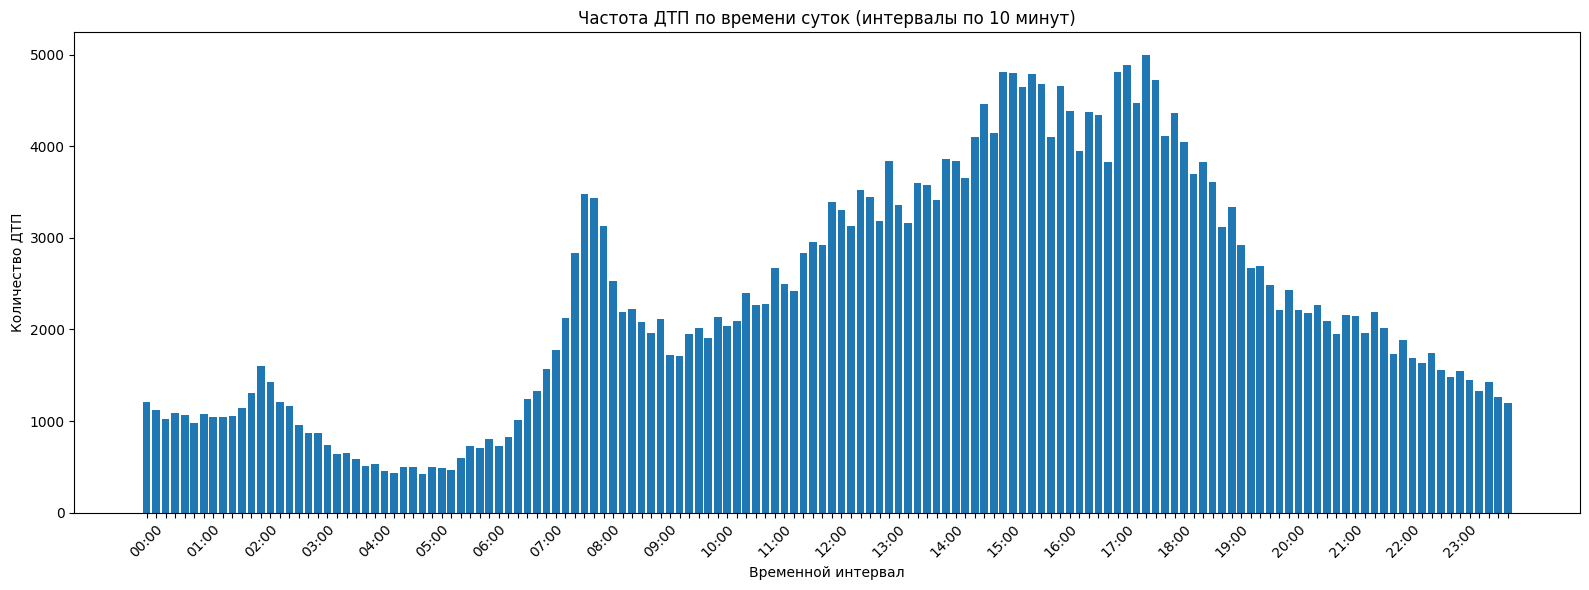

In [22]:
df_copy = df.copy()
df_copy['time_interval'] = pd.to_datetime(df_copy['collision_time'], format='%H:%M:%S').dt.floor('10min').dt.strftime('%H:%M')

plt.figure(figsize=(16, 6))
interval_counts = df_copy['time_interval'].value_counts().sort_index()

plt.bar(range(len(interval_counts)), interval_counts.values)
plt.title('Частота ДТП по времени суток (интервалы по 10 минут)')
plt.xlabel('Временной интервал')
plt.ylabel('Количество ДТП')

x_ticks = range(len(interval_counts))
x_labels = [label if i % 6 == 0 else '' for i, label in enumerate(interval_counts.index)]
plt.xticks(x_ticks, x_labels, rotation=45)

plt.tight_layout()
plt.show()

In [23]:
# создаем новые признаки из даты и времени
# сделаем месяц дтп и час дтп
df['month'] = pd.to_datetime(df['collision_date']).dt.month
df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour

In [24]:
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = df[col].fillna('unknown')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(-1)

In [25]:
# проверяем результат
drop_duplicated(df)
check_data(df)

np.int64(16)

'Удаляем'

<class 'pandas.core.frame.DataFrame'>
Index: 335967 entries, 0 to 409211
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   weather_1               335967 non-null  object        
 1   road_surface            335967 non-null  object        
 2   lighting                335967 non-null  object        
 3   intersection            335967 non-null  float64       
 4   pcf_violation_category  335967 non-null  object        
 5   type_of_collision       335967 non-null  object        
 6   road_condition_1        335967 non-null  object        
 7   direction               335967 non-null  object        
 8   distance                335967 non-null  float64       
 9   collision_date          335967 non-null  datetime64[ns]
 10  collision_time          335967 non-null  object        
 11  party_number            335967 non-null  int64         
 12  at_fault                335967 non-

None

,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission,month,hour
182686,cloudy,dry,daylight,1.0,unknown,broadside,normal,unknown,0.0,2010-11-05,13:15:00,1,0,had not been drinking,0.0,sedan,8,manual,11,13.0
337737,clear,dry,daylight,0.0,improper turning,sideswipe,normal,north,15.0,2009-05-11,19:44:00,2,0,had not been drinking,-1.0,sedan,7,auto,5,19.0
33205,cloudy,dry,dark with street lights,1.0,traffic signals and signs,sideswipe,normal,unknown,0.0,2011-03-11,21:14:00,1,1,had not been drinking,0.0,sedan,0,auto,3,21.0
330387,clear,dry,daylight,0.0,speeding,rear end,normal,west,40.0,2010-03-06,13:25:00,2,0,had not been drinking,0.0,sedan,4,manual,3,13.0
85822,raining,dry,daylight,0.0,speeding,rear end,normal,east,20.0,2011-09-25,14:10:00,2,0,impairment unknown,0.0,sedan,4,manual,9,14.0


Series([], dtype: int64)

None

,count,mean,min,25%,50%,75%,max,std
intersection,335967.0,0.265383,-1.0,0.0,0.0,1.0,1.0,0.453385
distance,335967.0,175.852892,0.0,0.0,66.0,271.0,1000.0,235.841348
collision_date,335967,2010-06-26 14:42:53.545616128,2009-01-01 00:00:00,2009-09-19 00:00:00,2010-06-24 00:00:00,2011-04-01 00:00:00,2011-12-31 00:00:00,NaN
party_number,335967.0,1.545012,1.0,1.0,1.0,2.0,13.0,0.656043
at_fault,335967.0,0.480461,0.0,0.0,0.0,1.0,1.0,0.499619
cellphone_in_use,335967.0,-0.088791,-1.0,0.0,0.0,0.0,1.0,0.339302
vehicle_age,335967.0,4.283117,0.0,2.0,4.0,6.0,10.0,2.590244
month,335967.0,6.57408,1.0,4.0,7.0,9.0,12.0,3.389378
hour,335967.0,13.467963,-1.0,10.0,14.0,17.0,23.0,5.558088


,weather_1,road_surface,lighting,intersection,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission,month,hour
0,cloudy,wet,dark with no street lights,0.0,other than driver (or pedestrian),other,normal,south,500.0,2009-03-22,05:30:00,1,0,had not been drinking,0.0,sedan,2,auto,3,5.0
1,clear,dry,daylight,1.0,automobile right of way,broadside,normal,unknown,0.0,2009-02-23,17:35:00,2,0,had not been drinking,0.0,sedan,1,manual,2,17.0
2,clear,dry,dark with street lights,1.0,automobile right of way,head-on,normal,unknown,0.0,2009-03-13,20:12:00,1,1,had not been drinking,0.0,sedan,5,auto,3,20.0
3,clear,dry,daylight,0.0,other than driver (or pedestrian),broadside,normal,north,45.0,2009-05-03,17:28:00,1,0,had not been drinking,-1.0,sedan,3,auto,5,17.0
4,clear,dry,dark with no street lights,0.0,unsafe lane change,hit object,normal,south,1000.0,2009-07-05,00:10:00,1,1,impairment unknown,-1.0,coupe,6,auto,7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409207,clear,dry,dark with street lights,1.0,improper turning,rear end,normal,unknown,0.0,2011-10-31,18:25:00,1,1,had not been drinking,-1.0,coupe,2,manual,10,18.0
409208,cloudy,dry,dark with street lights,0.0,dui,sideswipe,normal,west,528.0,2011-10-30,19:41:00,1,1,"had been drinking, under influence",0.0,coupe,9,manual,10,19.0
409209,clear,dry,daylight,0.0,improper turning,broadside,normal,south,100.0,2011-10-14,10:29:00,1,1,had not been drinking,0.0,sedan,0,auto,10,10.0
409210,clear,dry,daylight,1.0,speeding,rear end,normal,unknown,0.0,2011-10-19,11:28:00,2,0,had not been drinking,0.0,sedan,6,manual,10,11.0


### кореляция с таргетом

'=== Корреляция с таргетом ==='

party_number             -0.688188
vehicle_type             -0.125319
pcf_violation_category   -0.108205
party_sobriety           -0.107907
lighting                 -0.087017
hour                     -0.082266
vehicle_transmission      0.077795
vehicle_age              -0.072623
intersection             -0.067749
type_of_collision        -0.063872
distance                  0.040308
road_surface              0.038514
direction                -0.028602
weather_1                 0.024052
cellphone_in_use         -0.006292
month                    -0.005592
road_condition_1         -0.001912
Name: at_fault, dtype: float64

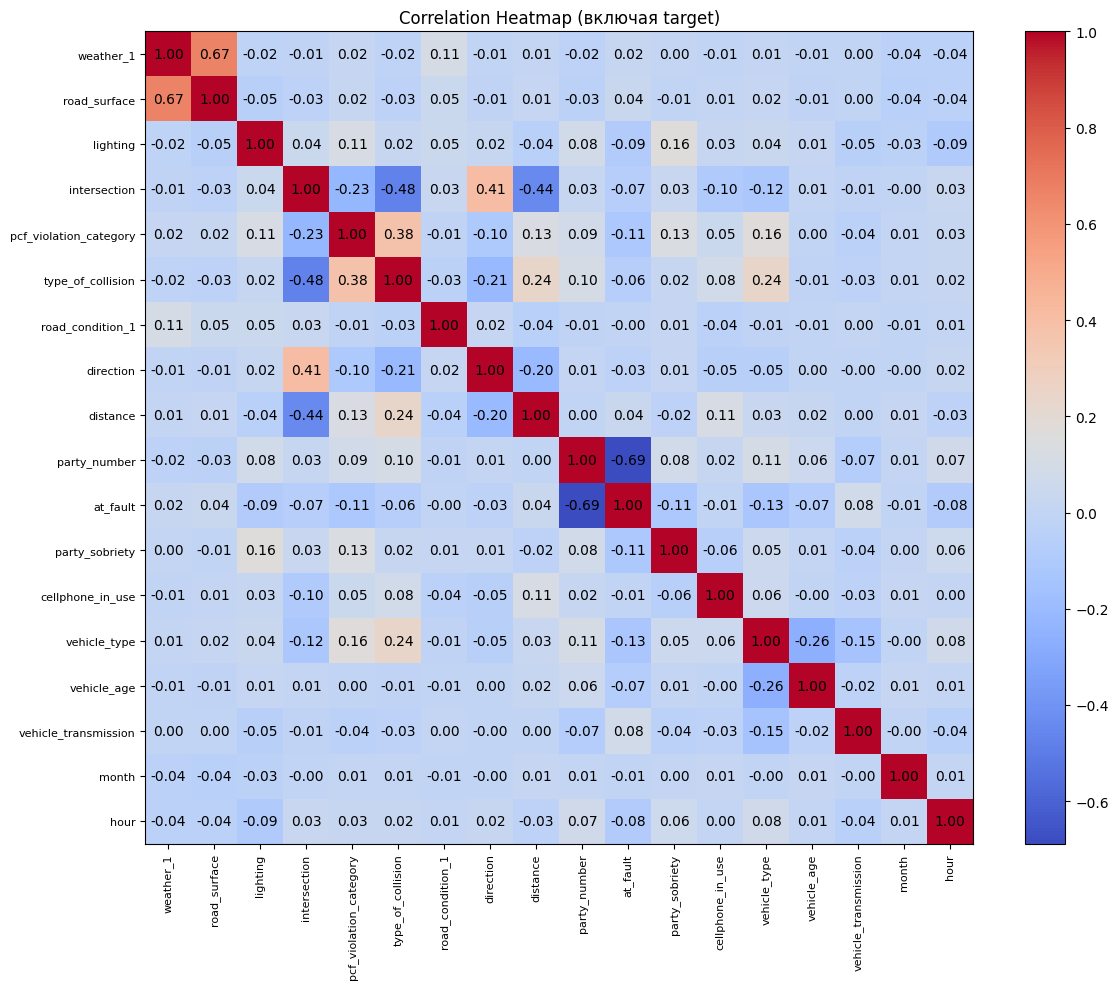

'=== VIF ==='

,feature,VIF
5,type_of_collision,2.285727
3,intersection,2.194242
0,weather_1,2.043428
1,road_surface,2.005285
4,pcf_violation_category,1.725143
12,vehicle_type,1.614586
14,vehicle_transmission,1.507304
9,party_number,1.456506
8,distance,1.341678
2,lighting,1.309258


In [26]:
df = df.drop(columns=['collision_date', 'collision_time'])
calc_target_correlations(df, target_col="at_fault")

# Обучение модели

In [27]:
# возьмем часть данных для подбора гиперпараметров и финального теста
df_rest, df_test = train_test_split(
    df, 
    test_size=0.05, 
    stratify=df['at_fault'], 
    random_state=RANDOM_STATE
)

logger.info("Распределение таргета:")
logger.info(f"Тест: {df_test['at_fault'].value_counts(normalize=True)}")
logger.info(f"Остальные: {df_rest['at_fault'].value_counts(normalize=True)}")

2025-11-26 17:49:34 [INFO] __main__: Распределение таргета:
2025-11-26 17:49:34 [INFO] __main__: Тест: at_fault
0    0.519555
1    0.480445
Name: proportion, dtype: float64
2025-11-26 17:49:34 [INFO] __main__: Остальные: at_fault
0    0.519538
1    0.480462
Name: proportion, dtype: float64


In [28]:
# разделим на выборки их оставшихся данных
X_train, X_val, y_train, y_val = train_test_split(
    df_rest.drop(['at_fault'], axis=1),
    df_rest['at_fault'],
    test_size=TEST_SIZE,
    stratify=df_rest['at_fault'],
    random_state=RANDOM_STATE
)

# финальный отложенный тест
X_final_test = df_test.drop(['at_fault'], axis=1)
y_final_test = df_test['at_fault']

In [29]:
# сюда будем писать результаты
results = {}

In [30]:
# разделяем признаки
# для ordinal ничего подходящего у нас нет
cat_selector = make_column_selector(dtype_include=["object", "category"])
num_selector = make_column_selector(dtype_exclude=["object", "category"])

In [31]:
cat_cols = cat_selector(X_train)
num_cols = num_selector(X_train)

display("Категориальные:", cat_cols)
display("Числовые:", num_cols)

'Категориальные:'

['weather_1',
 'road_surface',
 'lighting',
 'pcf_violation_category',
 'type_of_collision',
 'road_condition_1',
 'direction',
 'party_sobriety',
 'vehicle_type',
 'vehicle_transmission']

'Числовые:'

['intersection',
 'distance',
 'party_number',
 'cellphone_in_use',
 'vehicle_age',
 'month',
 'hour']

In [32]:
to_str = FunctionTransformer(lambda x: x.astype(str))

# для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_selector)
    ]
)

# для деревьев и бустингов
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_selector)
    ]
)

In [33]:
models = {
    "LogisticRegression": (lambda: LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight="balanced"), preprocessor_linear),
    "RandomForest": (lambda: RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight="balanced"), preprocessor_tree),
    "LightGBM": (lambda: LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree),
    "XGBoost": (lambda: XGBClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0, use_label_encoder=False), preprocessor_tree),
}


In [34]:
param_grid = {
    "LogisticRegression": {
        "C": (0.001, 10, "log")
    },
    "RandomForest": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 1500),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "DecisionTree": {
        "max_depth": (3, 40),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "LightGBM": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 40),
        "learning_rate": (0.01, 0.3, "log"),
        "num_leaves": (20, 128),
        "min_child_samples": (10, 60)
    },
    "XGBoost": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 40),
        "learning_rate": (0.01, 0.3, "log"),
        "subsample": (0.5, 1.0),
        "colsample_bytree": (0.5, 1.0)
    },
    "CatBoost": {
        "iterations": (100, 800, 100),
        "depth": (3, 16),
        "learning_rate": (0.01, 0.3, "log"),
        "l2_leaf_reg": (1, 8)
    }
}

In [35]:
def objective_model(trial, model_name, preprocessor):
    # train/val split внутри trial
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=TEST_SIZE,
        stratify=y_train,
        random_state=RANDOM_STATE
    )

    # SelectKBest
    k_best = trial.suggest_int("selectkbest__k", 1, X_train.shape[1])

    # Настройка модели
    pgrid = param_grid[model_name]

    if model_name == "LogisticRegression":
        C = suggest_param(trial, "C", pgrid["C"])
        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        model = cls(**model_params)

    elif model_name in ["LightGBM", "XGBoost", "CatBoost"]:
        cls = {"LightGBM": LGBMClassifier, "XGBoost": XGBClassifier}[model_name]
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE

        if model_name == "LightGBM":
            model_params["n_jobs"] = N_JOBS
            model_params["verbosity"] = -1
            model_params["class_weight"] = "balanced"
        elif model_name == "XGBoost":
            model_params["n_jobs"] = N_JOBS
            model_params["verbosity"] = 0
            model_params["use_label_encoder"] = False
            scale_pos_weight = (y_tr == 0).sum() / max(1, (y_tr == 1).sum())
            model_params["scale_pos_weight"] = scale_pos_weight
        else:  # CatBoost
            model_params["task_type"] = "CPU"
            model_params["thread_count"] = N_JOBS
            model_params["verbose"] = 0
            class_weight = [1.0, float((y_tr == 0).sum() / max(1, (y_tr == 1).sum()))]
            model_params["class_weights"] = class_weight

        model = cls(**model_params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best)),
        ("classifier", model)
    ])

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_val)  # Бинарные предсказания для F1

    f1 = f1_score(y_val, y_pred)

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return f1

## Подбор лучшей модели

In [36]:
best_models = {}
study_results = []

early_stop_cb = EarlyStoppingCallback(patience=EARLY_STOP)

def log_every_N_trials(study, trial, N=100):
    if trial.number % N == 0:
        best_trial = study.best_trial
        logger.info(
            f"[Trial {trial.number} finished]. Trial {best_trial.number} is best: F1={best_trial.value:.4f}, params={best_trial.params}"
        )

# Отключаем логи Optuna чтобы избежать дублирования
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

for model_name, (model_factory, preprocessor) in models.items():
    logger.info(f"\n\n=== Optimizing {model_name} ===")

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(direction="maximize", pruner=pruner)

    study.optimize(
        lambda trial: objective_model(trial, model_name, preprocessor),
        n_trials=N_ITER,
        callbacks=[log_every_N_trials, early_stop_cb]
    )

    best_params = study.best_params
    best_value = study.best_value
    logger.info(f"Best trial {study.best_trial.number} -> F1={best_value:.4f}, params={best_params}")

    # Финальный пайплайн
    k_best_final = best_params.get("selectkbest__k", X_train.shape[1])
    final_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best_final)),
        ("classifier", model_factory())
    ])

    # Применяем параметры к классификатору
    model_params = {k.replace("classifier__", ""): v for k, v in best_params.items() if k.startswith("classifier__")}
    if model_params:
        final_pipe.named_steps["classifier"].set_params(**model_params)

    final_pipe.fit(X_train, y_train)
    best_models[model_name] = final_pipe

    study_results.append({
        "Model": model_name,
        "Best_params": best_params,
        "F1_CV": best_value
    })

2025-11-26 17:49:34 [INFO] __main__: 

=== Optimizing LogisticRegression ===
2025-11-26 17:49:37 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.9066, params={'selectkbest__k': 11, 'C': 9.811479821555022}
2025-11-26 17:51:56 [INFO] func: Ранняя остановка: нет улучшений 50 trials
2025-11-26 17:51:56 [INFO] __main__: Best trial 51 -> F1=0.9084, params={'selectkbest__k': 17, 'C': 0.023459187123877758}
2025-11-26 17:51:58 [INFO] __main__: 

=== Optimizing RandomForest ===
2025-11-26 17:52:44 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.9083, params={'selectkbest__k': 11, 'n_estimators': 500, 'max_depth': 721, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}
2025-11-26 17:52:44 [INFO] func: Ранняя остановка: нет улучшений 50 trials
2025-11-26 17:52:44 [INFO] __main__: Best trial 0 -> F1=0.9083, params={'selectkbest__k': 11, 'n_estimators': 500, 'max_depth': 721, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}
2025-11-26 1

## Сравнение результатов

In [37]:
for res in study_results:
    name = res["Model"]
    model = best_models[name]

    # Предсказания вероятностей
    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict_proba(X_final_test)[:, 1]

    # Бинарные предсказания (порог 0.5)
    y_val_bin = (y_val_pred >= 0.5).astype(int)
    y_test_bin = (y_test_pred >= 0.5).astype(int)

    # ROC-AUC
    res["ROC_AUC_Val"] = roc_auc_score(y_val, y_val_pred)
    res["ROC_AUC_FinalTest"] = roc_auc_score(y_final_test, y_test_pred)
    
    # F1 Score
    res["F1_Val"] = f1_score(y_val, y_val_bin)
    res["F1_FinalTest"] = f1_score(y_final_test, y_test_bin)
    
    # Accuracy
    res["Accuracy_Val"] = accuracy_score(y_val, y_val_bin)
    res["Accuracy_FinalTest"] = accuracy_score(y_final_test, y_test_bin)

    # Confusion Matrix
    # cm = confusion_matrix(y_final_test, y_test_bin)
    # cm_df = pd.DataFrame(
    #     cm,
    #     index=["0", "1"],
    #     columns=["0", "1"]
    # )

    logger.info(f"=== {name} ===")
    # display(cm_df.style.set_caption("Confusion Matrix"))
    logger.info(f"F1 Score: {res['F1_FinalTest']:.4f}")
    logger.info("-" * 50)

# Сводная таблица по F1 Score (основная метрика)
results_df = pd.DataFrame(study_results)
display(results_df.sort_values("F1_FinalTest", ascending=False))

2025-11-26 17:53:30 [INFO] __main__: === LogisticRegression ===
2025-11-26 17:53:30 [INFO] __main__: F1 Score: 0.9080
2025-11-26 17:53:30 [INFO] __main__: --------------------------------------------------
2025-11-26 17:53:31 [INFO] __main__: === RandomForest ===
2025-11-26 17:53:31 [INFO] __main__: F1 Score: 0.8923
2025-11-26 17:53:31 [INFO] __main__: --------------------------------------------------
2025-11-26 17:53:32 [INFO] __main__: === LightGBM ===
2025-11-26 17:53:32 [INFO] __main__: F1 Score: 0.9104
2025-11-26 17:53:32 [INFO] __main__: --------------------------------------------------
2025-11-26 17:53:32 [INFO] __main__: === XGBoost ===
2025-11-26 17:53:32 [INFO] __main__: F1 Score: 0.9101
2025-11-26 17:53:32 [INFO] __main__: --------------------------------------------------


,Model,Best_params,F1_CV,ROC_AUC_Val,ROC_AUC_FinalTest,F1_Val,F1_FinalTest,Accuracy_Val,Accuracy_FinalTest
2,LightGBM,"{'selectkbest__k': 9, 'n_estimators': 500, 'ma...",0.905078,0.947755,0.948296,0.908398,0.910420,0.910393,0.912435
3,XGBoost,"{'selectkbest__k': 14, 'n_estimators': 400, 'm...",0.904732,0.950652,0.951401,0.908634,0.910066,0.910643,0.912138
0,LogisticRegression,"{'selectkbest__k': 17, 'C': 0.023459187123877758}",0.908358,0.939063,0.940278,0.906547,0.907953,0.908340,0.909816
1,RandomForest,"{'selectkbest__k': 11, 'n_estimators': 500, 'm...",0.908259,0.933768,0.933063,0.891493,0.892334,0.894821,0.895410
